## Summary of this page
1. data exploration
    - data type of different columns
    - Nan in data
2. features of data
    - Correlations between 
        - features and target
        - featutrs and features
3. predicting using lr model and xgboost
    - prediction
    - evaluation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost
import math
from __future__ import division
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1. Exploratory Data Analysis

- 涉及到
    - 不同列的数据类型
    - 缺失值的情况

In [3]:
# Read the data into a data frame
data = pd.read_csv('./input/kc_house_data.csv')

In [4]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [7]:
# Check the number of data points in the data set
print(len(data))
# Check the number of features in the data set
print(len(data.columns))
# Check the data types : int float object
print(data.dtypes.unique())

21613
21
[dtype('int64') dtype('O') dtype('float64')]


- Since there are Python objects in the data set, we may have some categorical features. Let's check them. 

In [8]:
# df.select_dtypes : Return a subset of a DataFrame including/excluding columns based on their dtype.
# so just data column is object data type.
data.select_dtypes(include=['O']).columns.tolist()

['date']

- We only have the date column which is a timestamp that we will ignore.

In [9]:
# Check any number of columns with NaN
print(data.isnull().any().sum(), ' / ', len(data.columns))
# Check any number of data points with NaN
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

0  /  21
0  /  21613


- The data set is pretty much structured and doesn't have any NaN values. So we can jump into finding correlations between the features and the target variable

# 2. Correlations between features and target

计算特征与目标值的相关系数

In [14]:
features = data.iloc[:,3:].columns.tolist()
target = data.iloc[:,2].name
print("Features are : ", features)
print("Target is : ", target)

Features are :  ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
Target is :  price


In [15]:
correlations = {}
for f in features:
    data_temp = data[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [16]:
correlations

{'bathrooms vs price': 0.52513750541396187,
 'bedrooms vs price': 0.30834959814563828,
 'condition vs price': 0.036361789128997554,
 'floors vs price': 0.25679388755071841,
 'grade vs price': 0.66743425602023709,
 'lat vs price': 0.3070034799952186,
 'long vs price': 0.021626241039305872,
 'sqft_above vs price': 0.60556729835607825,
 'sqft_basement vs price': 0.32381602071198395,
 'sqft_living vs price': 0.70203505461180005,
 'sqft_living15 vs price': 0.58537890357956801,
 'sqft_lot vs price': 0.089660860587100114,
 'sqft_lot15 vs price': 0.082447152519485978,
 'view vs price': 0.39729348829450428,
 'waterfront vs price': 0.26636943403060209,
 'yr_built vs price': 0.054011531494792715,
 'yr_renovated vs price': 0.12643379344089295,
 'zipcode vs price': -0.053202854298325608}

In [21]:
data_correlations = pd.DataFrame(correlations, index=['Value']).T

In [28]:
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
sqft_living vs price,0.702035
grade vs price,0.667434
sqft_above vs price,0.605567
sqft_living15 vs price,0.585379
bathrooms vs price,0.525138
view vs price,0.397293
sqft_basement vs price,0.323816
bedrooms vs price,0.308350
lat vs price,0.307003
waterfront vs price,0.266369


- We can see that the top 5 features are the most correlated features with the target "price"
- Let's plot the best 2 regressors jointly

In [29]:
y = data.loc[:,['sqft_living','grade',target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

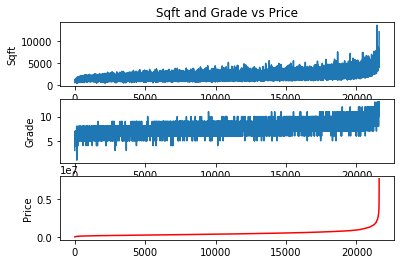

In [30]:
%matplotlib inline
plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('Sqft and Grade vs Price')
plt.ylabel('Sqft')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Grade')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel("Price")

plt.show()

# 3. Predicting House Sales Prices

In [31]:
# Train a simple linear regression model
regr = linear_model.LinearRegression()
new_data = data[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','lat','waterfront','yr_built','bedrooms']]

In [32]:
X = new_data.values
y = data.price.values

In [33]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y ,test_size=0.2)

In [34]:
regr.fit(X_train, y_train)
print(regr.predict(X_test))

[ 790453.67737448  312146.82484562  592978.79326572 ...,  602053.65586477
  298019.31480711  465116.43391607]


- sklearn 中每一个 model 都有一个自己的 score 方法，在其中默认定义了一些评价模型的指标
    - 比如分类模型中一般就是分类准确率
    - 回归模型中就是一个描述预测与实际值接近程度的一个指标

In [35]:
regr.score(X_test,y_test)

0.69736978132110183

- Prediction score is about 70 which is not really optimal

In [36]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))

RMSE: 200740.42


In [37]:
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [38]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

you can check [this page](http://www.cnblogs.com/nolonely/p/7009001.html) for more details of explained_variance_score()

In [39]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.820621177016


- Our accuracy is changing between 79%-84%. I think it is close to an optimal solution.